In [15]:
import pandas as pd
import datetime
import numpy as np

In [16]:
betting_df = pd.read_csv(r'C:\Users\ninuy\DSC 672\Data\NBA Betting Data Processed.csv')
game_df = pd.read_csv(r'C:\Users\ninuy\DSC 672\Data\NBA Team Box Score Stats Filtered with Rolling.csv', index_col=False)
injury_df = pd.read_csv(r'C:\Users\ninuy\DSC 672\Data\team_injury_impact.csv')
sentiment_df = pd.read_csv(r"C:\Users\ninuy\DSC 672\data\sentiment\nba_teams_sentiment_post2017.csv")

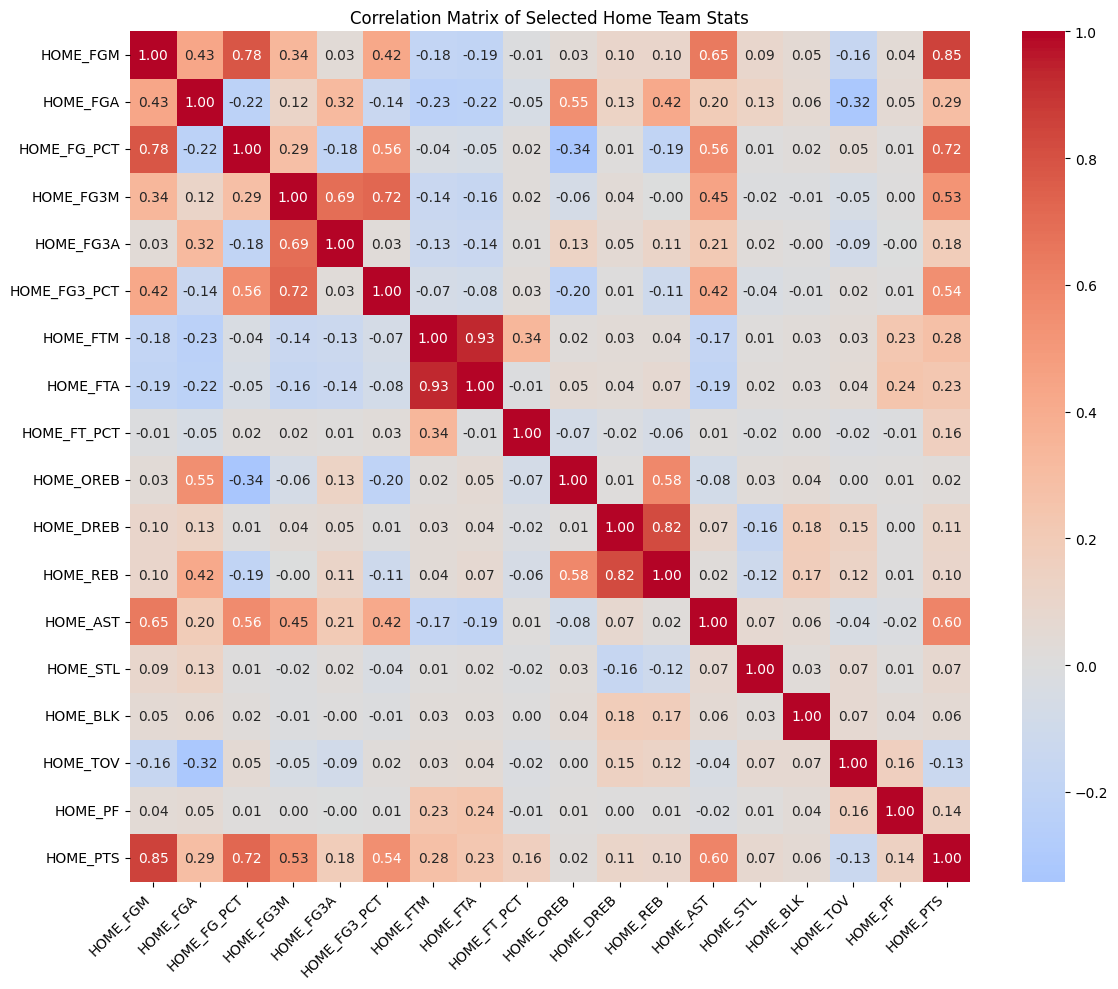

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define your selected HOME_ columns
home_columns = [
    'HOME_FGM', 'HOME_FGA', 'HOME_FG_PCT', 'HOME_FG3M', 'HOME_FG3A', 'HOME_FG3_PCT',
    'HOME_FTM', 'HOME_FTA', 'HOME_FT_PCT', 'HOME_OREB', 'HOME_DREB', 'HOME_REB',
    'HOME_AST', 'HOME_STL', 'HOME_BLK', 'HOME_TOV', 'HOME_PF', 'HOME_PTS'
]

# Subset the DataFrame
home_data = game_df[home_columns]

# Compute the correlation matrix
home_corr_matrix = home_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(home_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Selected Home Team Stats")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


C:\Users\ninuy\AppData\Local\Temp\ipykernel_35700\3441092327.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


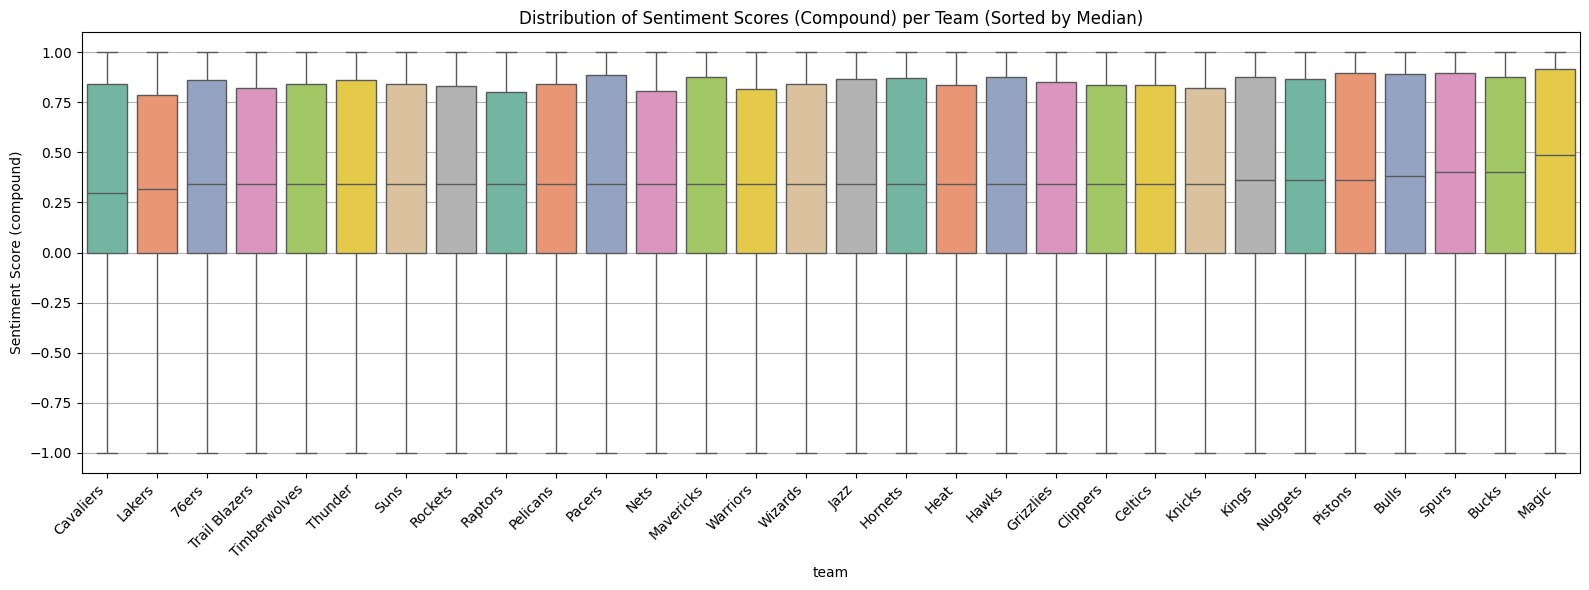

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate median sentiment per team
team_medians = sentiment_df.groupby('team')['compound'].median().sort_values()

# Step 2: Use this order in the boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(
    data=sentiment_df,
    x='team',
    y='compound',
    order=team_medians.index,  # <- sorted by median
    palette='Set2'
)

plt.title("Distribution of Sentiment Scores (Compound) per Team (Sorted by Median)")
plt.xlabel("team")
plt.ylabel("Sentiment Score (compound)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


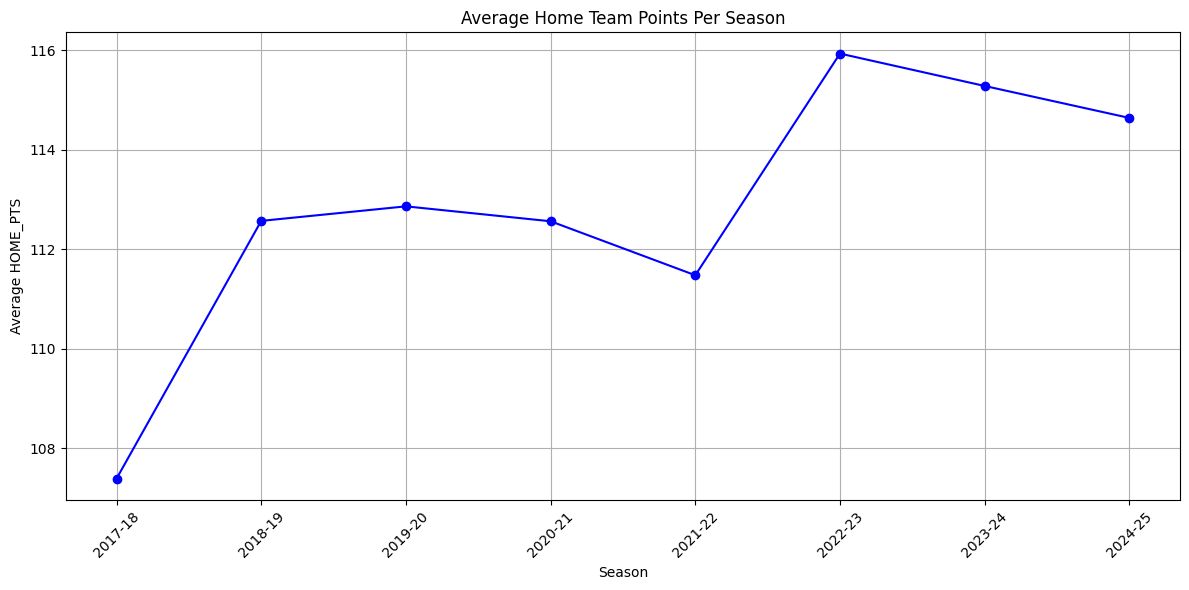

In [19]:
import matplotlib.pyplot as plt

# Group by SEASON and calculate the average HOME_PTS
season_avg = game_df.groupby('Season')['HOME_PTS'].mean().sort_index()

# Plot as a line chart
plt.figure(figsize=(12, 6))
plt.plot(season_avg.index, season_avg.values, marker='o', linestyle='-', color='blue')
plt.title("Average Home Team Points Per Season")
plt.xlabel("Season")
plt.ylabel("Average HOME_PTS")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:

betting_df['GAME_DATE'] = pd.to_datetime(betting_df['GAME_DATE'])
game_df['GAME_DATE'] = pd.to_datetime(game_df['GAME_DATE'])

merged_df = pd.merge(game_df, betting_df, on=['MATCHUP', 'GAME_DATE'], how='inner')

merged_df = merged_df.dropna()

merged_df['away_team'] = merged_df['MATCHUP'].str.split(' vs. ').str[1].str.strip()


In [21]:
# Ensure GAME_DATE is in datetime format
merged_df['GAME_DATE'] = pd.to_datetime(merged_df['GAME_DATE'])

# Sort by date to ensure chronological order
merged_df = merged_df.sort_values('GAME_DATE')

# Initialize dictionary to track each team's last game date
last_game_dates = {}

# Lists to store whether it's a back-to-back for home and away teams
home_b2b = []
away_b2b = []

# Iterate through the games
for _, row in merged_df.iterrows():
    game_date = row['GAME_DATE']
    home_team = row['TEAM_NAME']
    away_team = row['away_team']
    
    # Check home team back-to-back
    home_last_game = last_game_dates.get(home_team)
    if home_last_game is not None and (game_date - home_last_game).days == 1:
        home_b2b.append(1)
    else:
        home_b2b.append(0)
    last_game_dates[home_team] = game_date  # Update home team's last game date

    # Check away team back-to-back
    away_last_game = last_game_dates.get(away_team)
    if away_last_game is not None and (game_date - away_last_game).days == 1:
        away_b2b.append(1)
    else:
        away_b2b.append(0)
    last_game_dates[away_team] = game_date  # Update away team's last game date

# Add results to dataframe
merged_df['home_b2b'] = home_b2b
merged_df['away_b2b'] = away_b2b


In [22]:
import numpy as np
import pandas as pd

def evaluate_performance(
    y_true, y_pred, home_line,
    home_odds=-110, away_odds=-110, unit_value=10,
    low_thres=1.5, high_thres=4.0,
    unit_scheme=(1, 3, 5)
):
    low_units, mid_units, high_units = unit_scheme

    df = pd.DataFrame({
        'y_pred': y_pred,
        'y_true': y_true,
        'home_line': home_line,
        'home_odds': home_odds,
        'away_odds': away_odds
    })

    df['bet_on_home'] = df['y_pred'] > df['home_line']
    df['home_covered'] = df['y_true'] > df['home_line']
    df['bet_correct'] = df['bet_on_home'] == df['home_covered']
    df['confidence'] = abs(df['y_pred'] - df['home_line'])

    def bet_size(conf):
        if conf < low_thres:
            return low_units
        elif conf < high_thres:
            return mid_units
        else:
            return high_units

    df['bet_size'] = df['confidence'].apply(bet_size)

    def calculate_profit(row):
        odds = row['home_odds'] if row['bet_on_home'] else row['away_odds']
        bet_amount = row['bet_size'] * unit_value
        if row['bet_correct']:
            if odds > 0:
                return bet_amount * (odds / 100)
            else:
                return bet_amount / (abs(odds) / 100)
        else:
            return -bet_amount

    df['profit'] = df.apply(calculate_profit, axis=1)

    total_profit = df['profit'].sum()
    total_bet_amount = (df['bet_size'] * unit_value).sum()
    roi = total_profit / total_bet_amount if total_bet_amount != 0 else 0
    accuracy = df['bet_correct'].mean()

    return accuracy, total_profit, roi


## Model With Just Box Scores

In [23]:
# Ensure GAME_DATE is datetime
merged_df['GAME_DATE'] = pd.to_datetime(merged_df['GAME_DATE'])

# Sort by date ascending
merged_df = merged_df.sort_values('GAME_DATE').reset_index(drop=True)

# Calculate the index for 80% split
split_index = int(len(merged_df) * 0.8)

# Split into train and test based on index
train_df = merged_df.iloc[:split_index]
test_df = merged_df.iloc[split_index:]

# Separate features and target
X_train = train_df.drop(columns=['POINT_MARGIN'])
y_train = train_df['POINT_MARGIN']

X_test = test_df.drop(columns=['POINT_MARGIN'])
y_test = test_df['POINT_MARGIN']

accuracy_train = X_train['line']
accuracy_test = X_test['line']

In [24]:
# List of columns to keep
keep_cols = [
    'HOME_FG_PCT_5gm_avg',
    'HOME_FG3_PCT_5gm_avg',
    'HOME_FT_PCT_5gm_avg',
    'HOME_REB_5gm_avg',
    'HOME_AST_5gm_avg', 'HOME_STL_5gm_avg', 'HOME_BLK_5gm_avg',
    'HOME_TOV_5gm_avg', 'HOME_PF_5gm_avg', 'HOME_PTS_5gm_avg',
    'AWAY_FG_PCT_5gm_avg',
    'AWAY_FG3_PCT_5gm_avg',
    'AWAY_FT_PCT_5gm_avg',
    'AWAY_REB_5gm_avg',
    'AWAY_AST_5gm_avg', 'AWAY_STL_5gm_avg', 'AWAY_BLK_5gm_avg',
    'AWAY_TOV_5gm_avg', 'AWAY_PF_5gm_avg', 'AWAY_PTS_5gm_avg',
    'home_b2b', 'away_b2b'
]

# Drop all other columns
X_train = X_train[keep_cols]
X_test = X_test[keep_cols]

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV with TimeSeriesSplit
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # strength of regularization
}

tscv = TimeSeriesSplit(n_splits=5)

ridge = Ridge()
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,  # Use TimeSeriesSplit here
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best alpha:", best_params['alpha'])

# Step 2: TimeSeriesSplit Cross Validation with best hyperparameters
tscv_cv = TimeSeriesSplit(n_splits=5)
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv_cv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = Ridge(alpha=best_params['alpha'])
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Fit final model on full training data
final_model = Ridge(alpha=best_params['alpha'])
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds for training evaluation
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

ridge_final_model = final_model
ridge_oof_preds = oof_preds



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha: 1.0
Fold 1 - MAE: 10.84, RMSE: 13.89, R²: 0.07
Fold 2 - MAE: 11.19, RMSE: 14.00, R²: 0.04
Fold 3 - MAE: 11.52, RMSE: 14.59, R²: 0.07
Fold 4 - MAE: 11.29, RMSE: 14.38, R²: 0.05
Fold 5 - MAE: 11.20, RMSE: 14.37, R²: 0.06

=== Betting Performance ===
Train Accuracy: 50.97% | Profit: $-7634.55 | ROI: -3.05%
Test Accuracy: 49.67% | Profit: $-4387.27 | ROI: -6.77%


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np

# === Step 1: Hyperparameter Tuning with TimeSeriesSplit ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

tscv = TimeSeriesSplit(n_splits=3)  # For tuning, fewer splits can be enough

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=43),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,   # Use time-series aware split here
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# === Step 2: TimeSeriesSplit Cross-Validation with Best Params ===
tscv_cv = TimeSeriesSplit(n_splits=5)
oof_preds = np.zeros(len(X_train))  # to store out-of-fold train predictions

for fold, (train_idx, val_idx) in enumerate(tscv_cv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_model = RandomForestRegressor(**best_params, random_state=43)
    rf_model.fit(X_tr, y_tr)

    y_val_pred = rf_model.predict(X_val)
    oof_preds[val_idx] = y_val_pred  # save out-of-fold predictions

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# === Final Model on All Training Data ===
final_model = RandomForestRegressor(**best_params, random_state=43)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds for training evaluation
y_train_pred = oof_preds

# === Evaluate Betting Performance ===
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")


rf_final_model = final_model
rf_oof_preds = oof_preds
    

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Fold 1 - MAE: 11.05, RMSE: 14.16, R²: 0.04
Fold 2 - MAE: 11.33, RMSE: 14.18, R²: 0.01
Fold 3 - MAE: 11.68, RMSE: 14.78, R²: 0.04
Fold 4 - MAE: 11.40, RMSE: 14.53, R²: 0.03
Fold 5 - MAE: 11.30, RMSE: 14.45, R²: 0.05

=== Betting Performance ===
Train Accuracy: 50.79% | Profit: $-8410.91 | ROI: -3.31%
Test Accuracy: 49.06% | Profit: $-3800.00 | ROI: -5.82%


In [26]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV on the full training set with TimeSeriesSplit
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

xgb_model = xgb.XGBRegressor(random_state=43, verbosity=0)

tscv = TimeSeriesSplit(n_splits=5)  # time-series aware splitter

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,  # use TimeSeriesSplit here
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_params = grid_search.best_params_

# Step 2: Time Series Cross-validation with best hyperparameters from tuning
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = xgb.XGBRegressor(
        **best_params,
        random_state=43,
        verbosity=0
    )
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Final model trained on all training data with best hyperparameters
final_model = xgb.XGBRegressor(
    **best_params,
    random_state=43,
    verbosity=0
)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds as train predictions
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

xgb_final_model = final_model
xgb_oof_preds = oof_preds



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Fold 1 - MAE: 11.04, RMSE: 14.05, R²: 0.05
Fold 2 - MAE: 11.23, RMSE: 14.05, R²: 0.03
Fold 3 - MAE: 11.70, RMSE: 14.77, R²: 0.04
Fold 4 - MAE: 11.43, RMSE: 14.45, R²: 0.04
Fold 5 - MAE: 11.36, RMSE: 14.51, R²: 0.04

=== Betting Performance ===
Train Accuracy: 49.97% | Profit: $-8910.91 | ROI: -3.50%
Test Accuracy: 50.27% | Profit: $-3918.18 | ROI: -5.91%


In [27]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV with TimeSeriesSplit
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

gb_model = GradientBoostingRegressor(random_state=43)

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_params = grid_search.best_params_

# Step 2: Time Series Cross-validation with best hyperparameters
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = GradientBoostingRegressor(
        **best_params,
        random_state=43
    )
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Final model on full training set
final_model = GradientBoostingRegressor(
    **best_params,
    random_state=43
)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds as train predictions
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

gb_final_model = final_model
gb_oof_preds = oof_preds



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Fold 1 - MAE: 11.09, RMSE: 14.09, R²: 0.05
Fold 2 - MAE: 11.25, RMSE: 14.06, R²: 0.03
Fold 3 - MAE: 11.69, RMSE: 14.76, R²: 0.04
Fold 4 - MAE: 11.43, RMSE: 14.45, R²: 0.04
Fold 5 - MAE: 11.36, RMSE: 14.50, R²: 0.04

=== Betting Performance ===
Train Accuracy: 50.26% | Profit: $-9502.73 | ROI: -3.73%
Test Accuracy: 50.39% | Profit: $-3876.36 | ROI: -5.86%


In [30]:
# === Ensemble Model ===
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Collect predictions from individual final models
ridge_pred_test = ridge_final_model.predict(X_test)
rf_pred_test = rf_final_model.predict(X_test)
xgb_pred_test = xgb_final_model.predict(X_test)
gb_pred_test = gb_final_model.predict(X_test)

# Average predictions for ensemble
ensemble_pred_test = (ridge_pred_test + rf_pred_test + xgb_pred_test + gb_pred_test) / 4

# For training ensemble, average their OOF predictions
ridge_oof = ridge_oof_preds
rf_oof = rf_oof_preds
xgb_oof = xgb_oof_preds
gb_oof = gb_oof_preds

ensemble_oof = (ridge_oof + rf_oof + xgb_oof + gb_oof) / 4

# Evaluate ensemble performance
ensemble_train_accuracy, ensemble_train_profit, ensemble_train_roi = evaluate_performance(
    y_train, ensemble_oof, home_line=-accuracy_train
)
ensemble_test_accuracy, ensemble_test_profit, ensemble_test_roi = evaluate_performance(
    y_test, ensemble_pred_test, home_line=-accuracy_test
)

print("\n=== Ensemble Betting Performance ===")
print(f"Train Accuracy: {ensemble_train_accuracy:.2%} | Profit: ${ensemble_train_profit:.2f} | ROI: {ensemble_train_roi:.2%}")
print(f"Test Accuracy: {ensemble_test_accuracy:.2%} | Profit: ${ensemble_test_profit:.2f} | ROI: {ensemble_test_roi:.2%}")



=== Ensemble Betting Performance ===
Train Accuracy: 50.29% | Profit: $-9335.45 | ROI: -3.69%
Test Accuracy: 49.24% | Profit: $-3986.36 | ROI: -6.11%


## Model With Injuries

In [31]:
from nba_api.stats.static import teams

# Get all NBA teams and create a mapping
team_abbrev_map = {team['full_name']: team['abbreviation'] for team in teams.get_teams()}
team_abbrev_map['LA Clippers'] = 'LAC'
injury_df['team_abbrev'] = injury_df['TEAM'].map(team_abbrev_map)


In [32]:
def determine_home_or_away(row):    
    home = row['GAME'].split(' vs. ')[0].strip()
    away = row['GAME'].split(' vs. ')[1].strip()
    
    if row['team_abbrev'] == home:
        return 'home'
    elif row['team_abbrev'] == away:
        return 'away'
    else:
        return 'unknown'

injury_df['home_or_away'] = injury_df.apply(determine_home_or_away, axis=1)


In [33]:
home_impact_df = injury_df[injury_df['home_or_away'] == 'home'].copy()
away_impact_df = injury_df[injury_df['home_or_away'] == 'away'].copy()


In [34]:
home_impact_df = home_impact_df.rename(columns={
    'DATE' : 'GAME_DATE', 
    'GAME' : 'MATCHUP', 
    'team': 'home_team',
    'team_missing_bpm': 'home_missing_bpm'
})

away_impact_df = away_impact_df.rename(columns={
        'DATE' : 'GAME_DATE', 
    'GAME' : 'MATCHUP', 
    'team': 'away_team',
    'team_missing_bpm': 'away_missing_bpm'
})


In [35]:
merged_df['GAME_DATE'] = pd.to_datetime(merged_df['GAME_DATE'])
filtered_df = merged_df[(merged_df['GAME_DATE'] > '2021-10-18') & (merged_df['GAME_DATE'] < '2024-04-15')]

In [36]:
filtered_df['GAME_DATE'] = pd.to_datetime(filtered_df['GAME_DATE'])
home_impact_df['GAME_DATE'] = pd.to_datetime(home_impact_df['GAME_DATE'])
away_impact_df['GAME_DATE'] = pd.to_datetime(away_impact_df['GAME_DATE'])


C:\Users\ninuy\AppData\Local\Temp\ipykernel_35700\3123679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['GAME_DATE'] = pd.to_datetime(filtered_df['GAME_DATE'])


In [37]:
main_df = filtered_df.merge(
    home_impact_df[['MATCHUP', 'GAME_DATE', 'home_missing_bpm']],
    on=['MATCHUP', 'GAME_DATE'],
    how='left'
)

main_df = main_df.merge(
    away_impact_df[['MATCHUP', 'GAME_DATE', 'away_missing_bpm']],
    on=['MATCHUP', 'GAME_DATE'],
    how='left'
)


In [38]:
main_df['home_missing_bpm'] = main_df['home_missing_bpm'].fillna(0)
main_df['away_missing_bpm'] = main_df['away_missing_bpm'].fillna(0)

In [39]:
# Ensure GAME_DATE is datetime
main_df['GAME_DATE'] = pd.to_datetime(merged_df['GAME_DATE'])

# Sort by date ascending
main_df = main_df.sort_values('GAME_DATE').reset_index(drop=True)

# Calculate the index for 80% split
split_index = int(len(main_df) * 0.8)

# Split into train and test based on index
train_df = main_df.iloc[:split_index]
test_df = main_df.iloc[split_index:]

# Separate features and target
X_train = train_df.drop(columns=['POINT_MARGIN'])
y_train = train_df['POINT_MARGIN']

X_test = test_df.drop(columns=['POINT_MARGIN'])
y_test = test_df['POINT_MARGIN']

accuracy_train = X_train['line']
accuracy_test = X_test['line']

In [40]:
# List of columns to keep
keep_cols = [
    'HOME_FG_PCT_5gm_avg',
    'HOME_FG3_PCT_5gm_avg',
    'HOME_FT_PCT_5gm_avg',
    'HOME_REB_5gm_avg',
    'HOME_AST_5gm_avg', 'HOME_STL_5gm_avg', 'HOME_BLK_5gm_avg',
    'HOME_TOV_5gm_avg', 'HOME_PF_5gm_avg', 'HOME_PTS_5gm_avg',
    'AWAY_FG_PCT_5gm_avg',
    'AWAY_FG3_PCT_5gm_avg',
    'AWAY_FT_PCT_5gm_avg',
    'AWAY_REB_5gm_avg',
    'AWAY_AST_5gm_avg', 'AWAY_STL_5gm_avg', 'AWAY_BLK_5gm_avg',
    'AWAY_TOV_5gm_avg', 'AWAY_PF_5gm_avg', 'AWAY_PTS_5gm_avg',
    'home_missing_bpm', 'away_missing_bpm',
    'home_b2b', 'away_b2b'

]

# Drop all other columns
X_train = X_train[keep_cols]
X_test = X_test[keep_cols]

In [41]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV with TimeSeriesSplit
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # strength of regularization
}

tscv = TimeSeriesSplit(n_splits=5)

ridge = Ridge()
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,  # Use TimeSeriesSplit here
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best alpha:", best_params['alpha'])

# Step 2: TimeSeriesSplit Cross Validation with best hyperparameters
tscv_cv = TimeSeriesSplit(n_splits=5)
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv_cv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = Ridge(alpha=best_params['alpha'])
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Fit final model on full training data
final_model = Ridge(alpha=best_params['alpha'])
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds for training evaluation
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

ridge_final_model = final_model
ridge_oof_preds = oof_preds

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha: 100.0
Fold 1 - MAE: 11.93, RMSE: 15.14, R²: 0.03
Fold 2 - MAE: 11.42, RMSE: 14.36, R²: 0.06
Fold 3 - MAE: 10.33, RMSE: 13.01, R²: -0.00
Fold 4 - MAE: 10.75, RMSE: 13.64, R²: 0.07
Fold 5 - MAE: 11.82, RMSE: 15.40, R²: 0.09

=== Betting Performance ===
Train Accuracy: 49.58% | Profit: $-4042.73 | ROI: -4.31%
Test Accuracy: 48.97% | Profit: $-1639.09 | ROI: -6.80%


In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np

# === Step 1: Hyperparameter Tuning with TimeSeriesSplit ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

tscv = TimeSeriesSplit(n_splits=3)  # For tuning, fewer splits can be enough

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=43),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,   # Use time-series aware split here
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# === Step 2: TimeSeriesSplit Cross-Validation with Best Params ===
tscv_cv = TimeSeriesSplit(n_splits=5)
oof_preds = np.zeros(len(X_train))  # to store out-of-fold train predictions

for fold, (train_idx, val_idx) in enumerate(tscv_cv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_model = RandomForestRegressor(**best_params, random_state=43)
    rf_model.fit(X_tr, y_tr)

    y_val_pred = rf_model.predict(X_val)
    oof_preds[val_idx] = y_val_pred  # save out-of-fold predictions

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# === Final Model on All Training Data ===
final_model = RandomForestRegressor(**best_params, random_state=43)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds for training evaluation
y_train_pred = oof_preds

# === Evaluate Betting Performance ===
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

rf_final_model = final_model
rf_oof_preds = oof_preds


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Fold 1 - MAE: 12.24, RMSE: 15.41, R²: -0.00
Fold 2 - MAE: 11.65, RMSE: 14.63, R²: 0.03
Fold 3 - MAE: 10.37, RMSE: 13.09, R²: -0.01
Fold 4 - MAE: 10.98, RMSE: 13.85, R²: 0.04
Fold 5 - MAE: 12.02, RMSE: 15.63, R²: 0.07

=== Betting Performance ===
Train Accuracy: 49.86% | Profit: $-4465.45 | ROI: -4.65%
Test Accuracy: 48.97% | Profit: $-1615.45 | ROI: -6.51%


In [43]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV on the full training set with TimeSeriesSplit
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

xgb_model = xgb.XGBRegressor(random_state=43, verbosity=0)

tscv = TimeSeriesSplit(n_splits=5)  # time-series aware splitter

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,  # use TimeSeriesSplit here
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_params = grid_search.best_params_

# Step 2: Time Series Cross-validation with best hyperparameters from tuning
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = xgb.XGBRegressor(
        **best_params,
        random_state=43,
        verbosity=0
    )
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Final model trained on all training data with best hyperparameters
final_model = xgb.XGBRegressor(
    **best_params,
    random_state=43,
    verbosity=0
)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds as train predictions
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

xgb_final_model = final_model
xgb_oof_preds = oof_preds


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Fold 1 - MAE: 12.12, RMSE: 15.40, R²: 0.00
Fold 2 - MAE: 11.69, RMSE: 14.59, R²: 0.03
Fold 3 - MAE: 10.37, RMSE: 13.02, R²: -0.00
Fold 4 - MAE: 11.02, RMSE: 13.77, R²: 0.05
Fold 5 - MAE: 12.18, RMSE: 15.73, R²: 0.05

=== Betting Performance ===
Train Accuracy: 49.78% | Profit: $-4820.00 | ROI: -4.97%
Test Accuracy: 49.45% | Profit: $-1205.45 | ROI: -4.81%


In [44]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV with TimeSeriesSplit
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

gb_model = GradientBoostingRegressor(random_state=43)

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_params = grid_search.best_params_

# Step 2: Time Series Cross-validation with best hyperparameters
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = GradientBoostingRegressor(
        **best_params,
        random_state=43
    )
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Final model on full training set
final_model = GradientBoostingRegressor(
    **best_params,
    random_state=43
)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds as train predictions
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

gb_final_model = final_model
gb_oof_preds = oof_preds


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Fold 1 - MAE: 12.09, RMSE: 15.36, R²: 0.01
Fold 2 - MAE: 11.72, RMSE: 14.62, R²: 0.03
Fold 3 - MAE: 10.36, RMSE: 13.02, R²: -0.00
Fold 4 - MAE: 11.06, RMSE: 13.83, R²: 0.04
Fold 5 - MAE: 12.18, RMSE: 15.72, R²: 0.06

=== Betting Performance ===
Train Accuracy: 50.10% | Profit: $-4790.91 | ROI: -4.93%
Test Accuracy: 49.45% | Profit: $-1203.64 | ROI: -4.81%


In [45]:
# === Ensemble Model ===
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Collect predictions from individual final models
ridge_pred_test = ridge_final_model.predict(X_test)
rf_pred_test = rf_final_model.predict(X_test)
xgb_pred_test = xgb_final_model.predict(X_test)
gb_pred_test = gb_final_model.predict(X_test)

# Average predictions for ensemble
ensemble_pred_test = (ridge_pred_test + rf_pred_test + xgb_pred_test + gb_pred_test) / 4

# For training ensemble, average their OOF predictions
ridge_oof = ridge_oof_preds
rf_oof = rf_oof_preds
xgb_oof = xgb_oof_preds
gb_oof = gb_oof_preds

ensemble_oof = (ridge_oof + rf_oof + xgb_oof + gb_oof) / 4

# Evaluate ensemble performance
ensemble_train_accuracy, ensemble_train_profit, ensemble_train_roi = evaluate_performance(
    y_train, ensemble_oof, home_line=-accuracy_train
)
ensemble_test_accuracy, ensemble_test_profit, ensemble_test_roi = evaluate_performance(
    y_test, ensemble_pred_test, home_line=-accuracy_test
)

print("\n=== Ensemble Betting Performance ===")
print(f"Train Accuracy: {ensemble_train_accuracy:.2%} | Profit: ${ensemble_train_profit:.2f} | ROI: {ensemble_train_roi:.2%}")
print(f"Test Accuracy: {ensemble_test_accuracy:.2%} | Profit: ${ensemble_test_profit:.2f} | ROI: {ensemble_test_roi:.2%}")



=== Ensemble Betting Performance ===
Train Accuracy: 50.10% | Profit: $-4607.27 | ROI: -4.81%
Test Accuracy: 48.50% | Profit: $-1540.00 | ROI: -6.30%


## Model With Sentiment

In [46]:
import pandas as pd
import numpy as np

# Assume sentiment_df has columns: 'team', 'compound', 'created_at' (unix timestamp)

# Convert created_at to datetime with timezone awareness (assuming UTC, convert to ET)
sentiment_df['created_at'] = pd.to_datetime(sentiment_df['created_at'], unit='s').dt.tz_localize('UTC').dt.tz_convert('America/New_York')

# Extract date and time parts
sentiment_df['date'] = sentiment_df['created_at'].dt.date
sentiment_df['time'] = sentiment_df['created_at'].dt.time

# Define a function to get cutoff time (as a time object) per date
from datetime import time, datetime

def get_cutoff_time(date):
    # Check if Christmas Day
    if date.month == 12 and date.day == 25:
        return time(12, 0)  # 12 PM noon ET
    
    # Check weekday (Monday=0, Sunday=6)
    weekday = date.weekday()
    if weekday >= 5:  # Saturday or Sunday
        return time(12, 0)  # 12 PM noon ET
    else:
        return time(18, 0)  # 6 PM ET

# Apply cutoff filtering
def is_before_cutoff(row):
    cutoff = get_cutoff_time(row['created_at'].date())
    return row['created_at'].time() < cutoff

# Filter rows before cutoff time on their date
filtered_sentiment = sentiment_df[sentiment_df.apply(is_before_cutoff, axis=1)].copy()

# Now compute rolling average of compound sentiment over past 5 *dates* per team
# First, aggregate sentiment by team and date (mean compound)
daily_sentiment = (
    filtered_sentiment.groupby(['team', 'date'])['compound']
    .mean()
    .reset_index()
    .sort_values(['team', 'date'])
)

# Calculate rolling average for last 5 games/dates per team
daily_sentiment['rolling_avg_sentiment'] = (
    daily_sentiment.groupby('team')['compound']
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Now daily_sentiment has rolling average sentiment per team per date without leakage


In [47]:
daily_sentiment

,team,date,compound,rolling_avg_sentiment
0,76ers,2017-01-02,0.999000,0.999000
1,76ers,2017-01-03,0.999900,0.999450
2,76ers,2017-01-04,-0.797900,0.400333
3,76ers,2017-01-05,-0.014825,0.296544
4,76ers,2017-01-06,0.000000,0.237235
...,...,...,...,...
81191,Wizards,2024-12-27,0.327667,0.144547
81192,Wizards,2024-12-28,0.469500,0.238447
81193,Wizards,2024-12-29,0.034600,0.158247
81194,Wizards,2024-12-30,0.646467,0.334800


In [48]:
team_name_map = {
    "76ers": "Philadelphia 76ers",
    "Bucks": "Milwaukee Bucks",
    "Bulls": "Chicago Bulls",
    "Cavaliers": "Cleveland Cavaliers",
    "Celtics": "Boston Celtics",
    "Clippers": "LA Clippers",
    "Grizzlies": "Memphis Grizzlies",
    "Hawks": "Atlanta Hawks",
    "Heat": "Miami Heat",
    "Hornets": "Charlotte Hornets",
    "Jazz": "Utah Jazz",
    "Kings": "Sacramento Kings",
    "Knicks": "New York Knicks",
    "Lakers": "Los Angeles Lakers",
    "Magic": "Orlando Magic",
    "Mavericks": "Dallas Mavericks",
    "Nets": "Brooklyn Nets",
    "Nuggets": "Denver Nuggets",
    "Pacers": "Indiana Pacers",
    "Pelicans": "New Orleans Pelicans",
    "Pistons": "Detroit Pistons",
    "Raptors": "Toronto Raptors",
    "Rockets": "Houston Rockets",
    "Spurs": "San Antonio Spurs",
    "Suns": "Phoenix Suns",
    "Thunder": "Oklahoma City Thunder",
    "Timberwolves": "Minnesota Timberwolves",
    "Trail Blazers": "Portland Trail Blazers",
    "Warriors": "Golden State Warriors",
    "Wizards": "Washington Wizards"
}

daily_sentiment["TEAM_NAME"] = daily_sentiment["team"].map(team_name_map)
daily_sentiment["GAME_DATE"] = daily_sentiment["date"]



In [49]:
daily_sentiment['away_team'] = daily_sentiment['TEAM_NAME']

In [50]:
daily_sentiment

,team,date,compound,rolling_avg_sentiment,TEAM_NAME,GAME_DATE,away_team
0,76ers,2017-01-02,0.999000,0.999000,Philadelphia 76ers,2017-01-02,Philadelphia 76ers
1,76ers,2017-01-03,0.999900,0.999450,Philadelphia 76ers,2017-01-03,Philadelphia 76ers
2,76ers,2017-01-04,-0.797900,0.400333,Philadelphia 76ers,2017-01-04,Philadelphia 76ers
3,76ers,2017-01-05,-0.014825,0.296544,Philadelphia 76ers,2017-01-05,Philadelphia 76ers
4,76ers,2017-01-06,0.000000,0.237235,Philadelphia 76ers,2017-01-06,Philadelphia 76ers
...,...,...,...,...,...,...,...
81191,Wizards,2024-12-27,0.327667,0.144547,Washington Wizards,2024-12-27,Washington Wizards
81192,Wizards,2024-12-28,0.469500,0.238447,Washington Wizards,2024-12-28,Washington Wizards
81193,Wizards,2024-12-29,0.034600,0.158247,Washington Wizards,2024-12-29,Washington Wizards
81194,Wizards,2024-12-30,0.646467,0.334800,Washington Wizards,2024-12-30,Washington Wizards


In [51]:
# Ensure both GAME_DATE columns are in datetime format
merged_df['GAME_DATE'] = pd.to_datetime(game_df['GAME_DATE'])
daily_sentiment['GAME_DATE'] = pd.to_datetime(daily_sentiment['GAME_DATE'])

# Now perform the merge
merged2_df = merged_df.merge(
    daily_sentiment[["TEAM_NAME", "GAME_DATE", "rolling_avg_sentiment"]],
    left_on=["TEAM_NAME", "GAME_DATE"],
    right_on=["TEAM_NAME", "GAME_DATE"],
    how="left"
).rename(columns={"rolling_avg_sentiment": "home_sentiment"}).drop(columns=["TEAM_NAME"])


In [52]:
team_abbreviations = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BKN",
    "Charlotte Hornets": "CHA",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHX",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS"
}

# Map full team names to abbreviations
daily_sentiment['TEAM_ABBR'] = daily_sentiment['TEAM_NAME'].map(team_abbreviations)


In [53]:
merged2_df = merged2_df.merge(
    daily_sentiment[["TEAM_ABBR", "GAME_DATE", "rolling_avg_sentiment"]],
    left_on=["away_team", "GAME_DATE"],
    right_on=["TEAM_ABBR", "GAME_DATE"],
    how="left"
).rename(columns={"rolling_avg_sentiment": "away_sentiment"})

In [54]:
merged_df

,Season,Game_ID,TEAM_NAME,GAME_DATE,MATCHUP,WL,HOME_MIN,HOME_FGM,HOME_FGA,HOME_FG_PCT,...,AWAY_STL_5gm_avg,AWAY_BLK_5gm_avg,AWAY_TOV_5gm_avg,AWAY_PF_5gm_avg,AWAY_PTS_5gm_avg,Unnamed: 0,line,away_team,home_b2b,away_b2b
0,2017-18,21700110,Miami Heat,2017-10-27,MIA vs. CHI,W,240,34.0,83.0,0.410,...,10.2,3.4,14.2,18.8,107.8,109,-10.0,CHI,0,0
1,2017-18,21700112,Memphis Grizzlies,2017-10-29,MEM vs. ORL,L,240,39.0,82.0,0.476,...,6.2,6.4,15.2,25.2,95.2,110,-2.5,ORL,0,0
2,2017-18,21700128,Utah Jazz,2017-11-03,UTA vs. TOR,L,240,35.0,80.0,0.438,...,8.4,4.4,18.8,19.0,91.2,127,-1.5,TOR,0,0
3,2017-18,21700125,Dallas Mavericks,2017-11-06,DAL vs. NOP,L,240,34.0,88.0,0.386,...,8.4,4.0,14.6,20.4,109.8,124,4.5,NOP,0,0
4,2017-18,21700130,Los Angeles Lakers,2017-11-15,LAL vs. BKN,W,240,48.0,94.0,0.511,...,11.2,4.0,13.8,18.8,104.0,129,-3.0,BKN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8236,2024-25,22401195,Minnesota Timberwolves,2025-02-21,MIN vs. UTA,W,240,46.0,98.0,0.469,...,6.4,3.6,14.0,21.8,103.2,10036,-23.0,UTA,0,0
8237,2024-25,22401188,Brooklyn Nets,2025-02-24,BKN vs. NYK,L,240,38.0,74.0,0.514,...,10.8,5.0,15.8,18.6,120.8,10027,5.0,NYK,0,0
8238,2024-25,22401194,Memphis Grizzlies,2025-03-07,MEM vs. DAL,W,240,52.0,104.0,0.500,...,6.8,3.2,13.2,19.0,123.4,10035,1.5,DAL,0,0
8239,2024-25,22401189,Cleveland Cavaliers,2025-03-10,CLE vs. IND,L,290,44.0,115.0,0.383,...,8.4,3.0,14.0,17.0,115.2,10029,7.0,IND,0,0


In [55]:
merged2_df = merged2_df.dropna()

In [56]:
merged2_df

,Season,Game_ID,GAME_DATE,MATCHUP,WL,HOME_MIN,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,...,AWAY_PF_5gm_avg,AWAY_PTS_5gm_avg,Unnamed: 0,line,away_team,home_b2b,away_b2b,home_sentiment,TEAM_ABBR,away_sentiment
0,2017-18,21700110,2017-10-27,MIA vs. CHI,W,240,34.0,83.0,0.410,12.0,...,18.8,107.8,109,-10.0,CHI,0,0,0.368410,CHI,0.313761
1,2017-18,21700112,2017-10-29,MEM vs. ORL,L,240,39.0,82.0,0.476,10.0,...,25.2,95.2,110,-2.5,ORL,0,0,0.492857,ORL,0.434763
2,2017-18,21700128,2017-11-03,UTA vs. TOR,L,240,35.0,80.0,0.438,8.0,...,19.0,91.2,127,-1.5,TOR,0,0,0.444374,TOR,0.324433
3,2017-18,21700125,2017-11-06,DAL vs. NOP,L,240,34.0,88.0,0.386,9.0,...,20.4,109.8,124,4.5,NOP,0,0,0.017810,NOP,0.342912
4,2017-18,21700130,2017-11-15,LAL vs. BKN,W,240,48.0,94.0,0.511,9.0,...,18.8,104.0,129,-3.0,BKN,0,0,0.486642,BKN,0.437928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8223,2024-25,22401177,2024-12-19,NOP vs. MIA,L,240,38.0,95.0,0.400,14.0,...,17.6,108.4,10017,15.0,MIA,0,0,0.450905,MIA,0.280777
8224,2024-25,22401173,2024-12-21,PHI vs. ATL,L,240,43.0,97.0,0.443,12.0,...,13.4,120.8,10013,11.5,ATL,0,1,0.507355,ATL,0.517478
8225,2024-25,22401185,2024-12-22,LAL vs. HOU,W,240,53.0,87.0,0.609,19.0,...,18.6,118.6,10025,-14.0,HOU,0,0,0.452697,HOU,0.293465
8226,2024-25,22401187,2024-12-26,BOS vs. CHA,W,240,35.0,90.0,0.389,14.0,...,14.2,101.4,10028,-10.5,CHA,0,0,0.182102,CHA,0.190671


In [57]:
# Ensure GAME_DATE is datetime
merged2_df['GAME_DATE'] = pd.to_datetime(merged2_df['GAME_DATE'])

# Sort by date ascending
merged2_df = merged2_df.sort_values('GAME_DATE').reset_index(drop=True)

# Calculate the index for 80% split
split_index = int(len(merged2_df) * 0.8)

# Split into train and test based on index
train_df = merged2_df.iloc[:split_index]
test_df = merged2_df.iloc[split_index:]

# Separate features and target
X_train = train_df.drop(columns=['POINT_MARGIN'])
y_train = train_df['POINT_MARGIN']

X_test = test_df.drop(columns=['POINT_MARGIN'])
y_test = test_df['POINT_MARGIN']

accuracy_train = X_train['line']
accuracy_test = X_test['line']

In [58]:
# List of columns to keep
keep_cols = [
    'HOME_FG_PCT_5gm_avg',
    'HOME_FG3_PCT_5gm_avg',
    'HOME_FT_PCT_5gm_avg',
    'HOME_REB_5gm_avg',
    'HOME_AST_5gm_avg', 'HOME_STL_5gm_avg', 'HOME_BLK_5gm_avg',
    'HOME_TOV_5gm_avg', 'HOME_PF_5gm_avg', 'HOME_PTS_5gm_avg',
    'AWAY_FG_PCT_5gm_avg',
    'AWAY_FG3_PCT_5gm_avg',
    'AWAY_FT_PCT_5gm_avg',
    'AWAY_REB_5gm_avg',
    'AWAY_AST_5gm_avg', 'AWAY_STL_5gm_avg', 'AWAY_BLK_5gm_avg',
    'AWAY_TOV_5gm_avg', 'AWAY_PF_5gm_avg', 'AWAY_PTS_5gm_avg',
    'home_sentiment', 'away_sentiment',
    'home_b2b', 'away_b2b'

]

# Drop all other columns
X_train = X_train[keep_cols]
X_test = X_test[keep_cols]



In [59]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV with TimeSeriesSplit
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # strength of regularization
}

tscv = TimeSeriesSplit(n_splits=5)

ridge = Ridge()
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,  # Use TimeSeriesSplit here
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best alpha:", best_params['alpha'])

# Step 2: TimeSeriesSplit Cross Validation with best hyperparameters
tscv_cv = TimeSeriesSplit(n_splits=5)
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv_cv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = Ridge(alpha=best_params['alpha'])
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Fit final model on full training data
final_model = Ridge(alpha=best_params['alpha'])
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds for training evaluation
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

ridge_final_model = final_model
ridge_oof_preds = oof_preds


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha: 100.0
Fold 1 - MAE: 11.48, RMSE: 14.76, R²: 0.05
Fold 2 - MAE: 11.72, RMSE: 14.84, R²: 0.04
Fold 3 - MAE: 11.50, RMSE: 14.54, R²: 0.08
Fold 4 - MAE: 11.07, RMSE: 14.11, R²: 0.08
Fold 5 - MAE: 10.70, RMSE: 13.52, R²: 0.08

=== Betting Performance ===
Train Accuracy: 50.87% | Profit: $-5949.09 | ROI: -2.88%
Test Accuracy: 50.52% | Profit: $-1758.18 | ROI: -3.46%


In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np

# === Step 1: Hyperparameter Tuning with TimeSeriesSplit ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

tscv = TimeSeriesSplit(n_splits=3)  # For tuning, fewer splits can be enough

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=43),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,   # Use time-series aware split here
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# === Step 2: TimeSeriesSplit Cross-Validation with Best Params ===
tscv_cv = TimeSeriesSplit(n_splits=5)
oof_preds = np.zeros(len(X_train))  # to store out-of-fold train predictions

for fold, (train_idx, val_idx) in enumerate(tscv_cv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_model = RandomForestRegressor(**best_params, random_state=43)
    rf_model.fit(X_tr, y_tr)

    y_val_pred = rf_model.predict(X_val)
    oof_preds[val_idx] = y_val_pred  # save out-of-fold predictions

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# === Final Model on All Training Data ===
final_model = RandomForestRegressor(**best_params, random_state=43)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds for training evaluation
y_train_pred = oof_preds

# === Evaluate Betting Performance ===
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

rf_final_model = final_model
rf_oof_preds = oof_preds


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Fold 1 - MAE: 11.69, RMSE: 14.97, R²: 0.03
Fold 2 - MAE: 11.78, RMSE: 15.03, R²: 0.02
Fold 3 - MAE: 11.54, RMSE: 14.68, R²: 0.07
Fold 4 - MAE: 11.30, RMSE: 14.39, R²: 0.04
Fold 5 - MAE: 10.77, RMSE: 13.62, R²: 0.07

=== Betting Performance ===
Train Accuracy: 50.50% | Profit: $-6920.00 | ROI: -3.32%
Test Accuracy: 51.04% | Profit: $-1724.55 | ROI: -3.38%


In [61]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV on the full training set with TimeSeriesSplit
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

xgb_model = xgb.XGBRegressor(random_state=43, verbosity=0)

tscv = TimeSeriesSplit(n_splits=5)  # time-series aware splitter

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,  # use TimeSeriesSplit here
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_params = grid_search.best_params_

# Step 2: Time Series Cross-validation with best hyperparameters from tuning
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = xgb.XGBRegressor(
        **best_params,
        random_state=43,
        verbosity=0
    )
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Final model trained on all training data with best hyperparameters
final_model = xgb.XGBRegressor(
    **best_params,
    random_state=43,
    verbosity=0
)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds as train predictions
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

xgb_final_model = final_model
xgb_oof_preds = oof_preds


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Fold 1 - MAE: 11.63, RMSE: 14.91, R²: 0.03
Fold 2 - MAE: 11.79, RMSE: 15.03, R²: 0.02
Fold 3 - MAE: 11.58, RMSE: 14.69, R²: 0.06
Fold 4 - MAE: 11.25, RMSE: 14.28, R²: 0.06
Fold 5 - MAE: 10.72, RMSE: 13.56, R²: 0.07

=== Betting Performance ===
Train Accuracy: 50.63% | Profit: $-6080.91 | ROI: -2.90%
Test Accuracy: 51.56% | Profit: $-1083.64 | ROI: -2.08%


In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV with TimeSeriesSplit
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

gb_model = GradientBoostingRegressor(random_state=43)

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_params = grid_search.best_params_

# Step 2: Time Series Cross-validation with best hyperparameters
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = GradientBoostingRegressor(
        **best_params,
        random_state=43
    )
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Final model on full training set
final_model = GradientBoostingRegressor(
    **best_params,
    random_state=43
)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds as train predictions
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

gb_final_model = final_model
gb_oof_preds = oof_preds

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Fold 1 - MAE: 11.61, RMSE: 14.89, R²: 0.04
Fold 2 - MAE: 11.77, RMSE: 14.99, R²: 0.02
Fold 3 - MAE: 11.60, RMSE: 14.68, R²: 0.07
Fold 4 - MAE: 11.25, RMSE: 14.33, R²: 0.05
Fold 5 - MAE: 10.74, RMSE: 13.58, R²: 0.07

=== Betting Performance ===
Train Accuracy: 50.43% | Profit: $-5403.64 | ROI: -2.58%
Test Accuracy: 51.63% | Profit: $-1219.09 | ROI: -2.36%


In [63]:
# === Ensemble Model ===
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Collect predictions from individual final models
ridge_pred_test = ridge_final_model.predict(X_test)
rf_pred_test = rf_final_model.predict(X_test)
xgb_pred_test = xgb_final_model.predict(X_test)
gb_pred_test = gb_final_model.predict(X_test)

# Average predictions for ensemble
ensemble_pred_test = (ridge_pred_test + rf_pred_test + xgb_pred_test + gb_pred_test) / 4

# For training ensemble, average their OOF predictions
ridge_oof = ridge_oof_preds
rf_oof = rf_oof_preds
xgb_oof = xgb_oof_preds
gb_oof = gb_oof_preds

ensemble_oof = (ridge_oof + rf_oof + xgb_oof + gb_oof) / 4

# Evaluate ensemble performance
ensemble_train_accuracy, ensemble_train_profit, ensemble_train_roi = evaluate_performance(
    y_train, ensemble_oof, home_line=-accuracy_train
)
ensemble_test_accuracy, ensemble_test_profit, ensemble_test_roi = evaluate_performance(
    y_test, ensemble_pred_test, home_line=-accuracy_test
)

print("\n=== Ensemble Betting Performance ===")
print(f"Train Accuracy: {ensemble_train_accuracy:.2%} | Profit: ${ensemble_train_profit:.2f} | ROI: {ensemble_train_roi:.2%}")
print(f"Test Accuracy: {ensemble_test_accuracy:.2%} | Profit: ${ensemble_test_profit:.2f} | ROI: {ensemble_test_roi:.2%}")



=== Ensemble Betting Performance ===
Train Accuracy: 50.74% | Profit: $-5519.09 | ROI: -2.66%
Test Accuracy: 51.70% | Profit: $-1467.27 | ROI: -2.87%


## Model with Injuries and Sentiment

In [64]:
merged3_df = main_df.merge(
    daily_sentiment[["TEAM_ABBR", "GAME_DATE", "rolling_avg_sentiment"]],
    left_on=["away_team", "GAME_DATE"],
    right_on=["TEAM_ABBR", "GAME_DATE"],
    how="left"
).rename(columns={"rolling_avg_sentiment": "away_sentiment"})

merged3_df = merged3_df.merge(
    daily_sentiment[["TEAM_NAME", "GAME_DATE", "rolling_avg_sentiment"]],
    left_on=["TEAM_NAME", "GAME_DATE"],
    right_on=["TEAM_NAME", "GAME_DATE"],
    how="left"
).rename(columns={"rolling_avg_sentiment": "home_sentiment"}).drop(columns=["TEAM_NAME"])

merged3_df = merged3_df.dropna()



In [65]:
# Ensure GAME_DATE is datetime
merged3_df['GAME_DATE'] = pd.to_datetime(merged3_df['GAME_DATE'])

# Sort by date ascending
merged3_df = merged3_df.sort_values('GAME_DATE').reset_index(drop=True)

# Calculate the index for 80% split
split_index = int(len(merged3_df) * 0.8)

# Split into train and test based on index
train_df = merged3_df.iloc[:split_index]
test_df = merged3_df.iloc[split_index:]

# Separate features and target
X_train = train_df.drop(columns=['POINT_MARGIN'])
y_train = train_df['POINT_MARGIN']

X_test = test_df.drop(columns=['POINT_MARGIN'])
y_test = test_df['POINT_MARGIN']

accuracy_train = X_train['line']
accuracy_test = X_test['line']

In [66]:
# List of columns to keep
keep_cols = [
    'HOME_FG_PCT_5gm_avg',
    'HOME_FG3_PCT_5gm_avg',
    'HOME_FT_PCT_5gm_avg',
    'HOME_REB_5gm_avg',
    'HOME_AST_5gm_avg', 'HOME_STL_5gm_avg', 'HOME_BLK_5gm_avg',
    'HOME_TOV_5gm_avg', 'HOME_PF_5gm_avg', 'HOME_PTS_5gm_avg',
    'AWAY_FG_PCT_5gm_avg',
    'AWAY_FG3_PCT_5gm_avg',
    'AWAY_FT_PCT_5gm_avg',
    'AWAY_REB_5gm_avg',
    'AWAY_AST_5gm_avg', 'AWAY_STL_5gm_avg', 'AWAY_BLK_5gm_avg',
    'AWAY_TOV_5gm_avg', 'AWAY_PF_5gm_avg', 'AWAY_PTS_5gm_avg',
    'home_sentiment', 'away_sentiment', 'home_missing_bpm', 'away_missing_bpm',
    'home_b2b', 'away_b2b'

]

# Drop all other columns
X_train = X_train[keep_cols]
X_test = X_test[keep_cols]



In [67]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV with TimeSeriesSplit
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # strength of regularization
}

tscv = TimeSeriesSplit(n_splits=5)

ridge = Ridge()
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,  # Use TimeSeriesSplit here
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best alpha:", best_params['alpha'])

# Step 2: TimeSeriesSplit Cross Validation with best hyperparameters
tscv_cv = TimeSeriesSplit(n_splits=5)
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv_cv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = Ridge(alpha=best_params['alpha'])
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Fit final model on full training data
final_model = Ridge(alpha=best_params['alpha'])
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds for training evaluation
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

ridge_final_model = final_model
ridge_oof_preds = oof_preds


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha: 100.0
Fold 1 - MAE: 11.80, RMSE: 15.03, R²: 0.03
Fold 2 - MAE: 10.82, RMSE: 13.58, R²: 0.07
Fold 3 - MAE: 10.60, RMSE: 13.39, R²: -0.00
Fold 4 - MAE: 10.80, RMSE: 13.82, R²: 0.08
Fold 5 - MAE: 11.97, RMSE: 15.55, R²: 0.09

=== Betting Performance ===
Train Accuracy: 49.58% | Profit: $-3408.18 | ROI: -4.00%
Test Accuracy: 47.78% | Profit: $-1912.73 | ROI: -8.98%


In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np

# === Step 1: Hyperparameter Tuning with TimeSeriesSplit ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

tscv = TimeSeriesSplit(n_splits=3)  # For tuning, fewer splits can be enough

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=43),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,   # Use time-series aware split here
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# === Step 2: TimeSeriesSplit Cross-Validation with Best Params ===
tscv_cv = TimeSeriesSplit(n_splits=5)
oof_preds = np.zeros(len(X_train))  # to store out-of-fold train predictions

for fold, (train_idx, val_idx) in enumerate(tscv_cv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_model = RandomForestRegressor(**best_params, random_state=43)
    rf_model.fit(X_tr, y_tr)

    y_val_pred = rf_model.predict(X_val)
    oof_preds[val_idx] = y_val_pred  # save out-of-fold predictions

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# === Final Model on All Training Data ===
final_model = RandomForestRegressor(**best_params, random_state=43)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds for training evaluation
y_train_pred = oof_preds

# === Evaluate Betting Performance ===
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

rf_final_model = final_model
rf_oof_preds = oof_preds


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Fold 1 - MAE: 11.88, RMSE: 14.94, R²: 0.04
Fold 2 - MAE: 11.32, RMSE: 14.07, R²: 0.00
Fold 3 - MAE: 10.73, RMSE: 13.56, R²: -0.03
Fold 4 - MAE: 10.93, RMSE: 13.88, R²: 0.07
Fold 5 - MAE: 12.22, RMSE: 15.83, R²: 0.05

=== Betting Performance ===
Train Accuracy: 49.89% | Profit: $-2780.00 | ROI: -3.21%
Test Accuracy: 47.42% | Profit: $-2047.27 | ROI: -9.24%


In [69]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV on the full training set with TimeSeriesSplit
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

xgb_model = xgb.XGBRegressor(random_state=43, verbosity=0)

tscv = TimeSeriesSplit(n_splits=5)  # time-series aware splitter

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,  # use TimeSeriesSplit here
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_params = grid_search.best_params_

# Step 2: Time Series Cross-validation with best hyperparameters from tuning
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = xgb.XGBRegressor(
        **best_params,
        random_state=43,
        verbosity=0
    )
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Final model trained on all training data with best hyperparameters
final_model = xgb.XGBRegressor(
    **best_params,
    random_state=43,
    verbosity=0
)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds as train predictions
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

xgb_final_model = final_model
xgb_oof_preds = oof_preds


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Fold 1 - MAE: 11.98, RMSE: 15.12, R²: 0.01
Fold 2 - MAE: 11.34, RMSE: 14.06, R²: 0.00
Fold 3 - MAE: 10.64, RMSE: 13.44, R²: -0.01
Fold 4 - MAE: 11.04, RMSE: 13.96, R²: 0.06
Fold 5 - MAE: 12.26, RMSE: 15.84, R²: 0.05

=== Betting Performance ===
Train Accuracy: 50.20% | Profit: $-3517.27 | ROI: -4.05%
Test Accuracy: 48.31% | Profit: $-1615.45 | ROI: -7.38%


In [70]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Hyperparameter tuning using GridSearchCV with TimeSeriesSplit
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

gb_model = GradientBoostingRegressor(random_state=43)

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_params = grid_search.best_params_

# Step 2: Time Series Cross-validation with best hyperparameters
oof_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = GradientBoostingRegressor(
        **best_params,
        random_state=43
    )
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    oof_preds[val_idx] = y_val_pred

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Final model on full training set
final_model = GradientBoostingRegressor(
    **best_params,
    random_state=43
)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Use OOF preds as train predictions
y_train_pred = oof_preds

# Evaluate betting performance
train_accuracy, train_profit, train_roi = evaluate_performance(y_train, y_train_pred, home_line=-accuracy_train)
test_accuracy, test_profit, test_roi = evaluate_performance(y_test, y_test_pred, home_line=-accuracy_test)

print("\n=== Betting Performance ===")
print(f"Train Accuracy: {train_accuracy:.2%} | Profit: ${train_profit:.2f} | ROI: {train_roi:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%} | Profit: ${test_profit:.2f} | ROI: {test_roi:.2%}")

gb_final_model = final_model
gb_oof_preds = oof_preds


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Fold 1 - MAE: 11.91, RMSE: 15.06, R²: 0.02
Fold 2 - MAE: 11.34, RMSE: 14.08, R²: 0.00
Fold 3 - MAE: 10.63, RMSE: 13.41, R²: -0.00
Fold 4 - MAE: 11.07, RMSE: 13.99, R²: 0.06
Fold 5 - MAE: 12.29, RMSE: 15.85, R²: 0.05

=== Betting Performance ===
Train Accuracy: 49.89% | Profit: $-3447.27 | ROI: -3.96%
Test Accuracy: 48.67% | Profit: $-1462.73 | ROI: -6.68%


In [71]:
# === Ensemble Model ===
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Collect predictions from individual final models
ridge_pred_test = ridge_final_model.predict(X_test)
rf_pred_test = rf_final_model.predict(X_test)
xgb_pred_test = xgb_final_model.predict(X_test)
gb_pred_test = gb_final_model.predict(X_test)

# Average predictions for ensemble
ensemble_pred_test = (ridge_pred_test + rf_pred_test + xgb_pred_test + gb_pred_test) / 4

# For training ensemble, average their OOF predictions
ridge_oof = ridge_oof_preds
rf_oof = rf_oof_preds
xgb_oof = xgb_oof_preds
gb_oof = gb_oof_preds

ensemble_oof = (ridge_oof + rf_oof + xgb_oof + gb_oof) / 4

# Evaluate ensemble performance
ensemble_train_accuracy, ensemble_train_profit, ensemble_train_roi = evaluate_performance(
    y_train, ensemble_oof, home_line=-accuracy_train
)
ensemble_test_accuracy, ensemble_test_profit, ensemble_test_roi = evaluate_performance(
    y_test, ensemble_pred_test, home_line=-accuracy_test
)

print("\n=== Ensemble Betting Performance ===")
print(f"Train Accuracy: {ensemble_train_accuracy:.2%} | Profit: ${ensemble_train_profit:.2f} | ROI: {ensemble_train_roi:.2%}")
print(f"Test Accuracy: {ensemble_test_accuracy:.2%} | Profit: ${ensemble_test_profit:.2f} | ROI: {ensemble_test_roi:.2%}")



=== Ensemble Betting Performance ===
Train Accuracy: 49.76% | Profit: $-3188.18 | ROI: -3.71%
Test Accuracy: 46.89% | Profit: $-1830.00 | ROI: -8.48%
